### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 10/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 10/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 10/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 10/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 10/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 10/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 10/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((295791, 32, 32),
 (85970, 32, 32),
 (73948, 32, 32),
 (295791, 10),
 (85970, 10),
 (73948, 10))

In [5]:
X_train[0]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       ...,
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ]], dtype=float32)

In [6]:
X_val[0]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451]], dtype=float32)

In [7]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

def channel_shuffle(x, groups):
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    group_channels = channels // groups

    x = tf.reshape(x, [-1, height, width, groups, group_channels])
    x = tf.transpose(x, [0, 1, 2, 4, 3])
    x = tf.reshape(x, [-1, height, width, channels])
    return x

def grouped_convolution(x, out_channels, groups):
    in_channels = x.shape[-1]
    group_list = []

    for i in range(groups):
        group_list.append(layers.Conv2D(out_channels // groups, kernel_size=1, strides=1, padding='same',
                                        use_bias=False)(x[:, :, :, i * in_channels // groups:(i + 1) * in_channels // groups]))
    return layers.Concatenate()(group_list)

def shuffle_unit(inputs, in_channels, out_channels, strides, groups):
    x = grouped_convolution(inputs, in_channels, groups)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = grouped_convolution(x, out_channels if strides == 1 else out_channels - in_channels, groups)
    x = layers.BatchNormalization()(x)

    if strides == 2:
        shortcut = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(inputs)
        x = layers.Concatenate()([x, shortcut])
    elif strides == 1:
        x = layers.Add()([inputs, x])

    x = layers.ReLU()(x)
    x = channel_shuffle(x, groups)
    return x

def ShuffleNet(input_shape=(224, 224, 3), num_classes=1000, scale_factor=1.0, groups=3):
    in_channels = 24
    out_channels = {1: [144, 288, 576], 2: [200, 400, 800], 3: [240, 480, 960], 4: [272, 544, 1088], 8: [384, 768, 1536]}[groups]
    out_channels = [int(c * scale_factor) for c in out_channels]

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(in_channels, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for out_channel in out_channels:
        repeat = 4 if out_channel != out_channels[0] else 3
        for i in range(repeat):
            strides = 2 if i == 0 else 1
            x = shuffle_unit(x, in_channels, out_channel, strides, groups)
            in_channels = out_channel

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
model = ShuffleNet(input_shape = (32,32,1), num_classes = 10)
from keras.optimizers import SGD
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 24)           216       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 24)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 24)           0         ['batch_normalization[0][0

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuraccy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
1156/1155 [==============================] - ETA: 0s - loss: 2.1060 - accuracy: 0.2566 - f1_m: 0.1113 - precision_m: 0.5041 - recall_m: 0.0641

1155/1155 [==============================] - 180s 127ms/step - loss: 2.1060 - accuracy: 0.2566 - f1_m: 0.1113 - precision_m: 0.5041 - recall_m: 0.0641 - val_loss: 1.9725 - val_accuracy: 0.2920 - val_f1_m: 0.2057 - val_precision_m: 0.5111 - val_recall_m: 0.1291
Epoch 2/50
1156/1155 [==============================] - ETA: 0s - loss: 1.7385 - accuracy: 0.3773 - f1_m: 0.2531 - precision_m: 0.6473 - recall_m: 0.1581

1155/1155 [==============================] - 145s 126ms/step - loss: 1.7385 - accuracy: 0.3773 - f1_m: 0.2531 - precision_m: 0.6473 - recall_m: 0.1581 - val_loss: 1.9024 - val_accuracy: 0.3368 - val_f1_m: 0.2322 - val_precision_m: 0.5910 - val_recall_m: 0.1449
Epoch 3/50
1156/1155 [==============================] - ETA: 0s - loss: 1.5812 - accuracy: 0.4297 - f1_m: 0.3262 - precision_m: 0.6750 - recall_m: 0.2157

1155/1155 [==============================] - 142s 123ms/step - loss: 1.5812 - accuracy: 0.4297 - f1_m: 0.3262 - precision_m: 0.6750 - recall_m: 0.2157 - val_loss: 1.5332 - val_accuracy: 0.4464 - val_f1_m: 0.3625 - val_precision_m: 0.6780 - val_recall_m: 0.2478
Epoch 4/50
1156/1155 [==============================] - ETA: 0s - loss: 1.4753 - accuracy: 0.4684 - f1_m: 0.3825 - precision_m: 0.6951 - recall_m: 0.2645

1155/1155 [==============================] - 142s 123ms/step - loss: 1.4753 - accuracy: 0.4684 - f1_m: 0.3825 - precision_m: 0.6951 - recall_m: 0.2645 - val_loss: 1.5237 - val_accuracy: 0.4579 - val_f1_m: 0.3909 - val_precision_m: 0.6391 - val_recall_m: 0.2820
Epoch 5/50
1156/1155 [==============================] - ETA: 0s - loss: 1.3905 - accuracy: 0.5003 - f1_m: 0.4298 - precision_m: 0.7128 - recall_m: 0.3082

1155/1155 [==============================] - 140s 121ms/step - loss: 1.3905 - accuracy: 0.5003 - f1_m: 0.4298 - precision_m: 0.7128 - recall_m: 0.3082 - val_loss: 1.3665 - val_accuracy: 0.5095 - val_f1_m: 0.4552 - val_precision_m: 0.7143 - val_recall_m: 0.3345
Epoch 6/50
1156/1155 [==============================] - ETA: 0s - loss: 1.3284 - accuracy: 0.5247 - f1_m: 0.4654 - precision_m: 0.7263 - recall_m: 0.3429

1155/1155 [==============================] - 143s 124ms/step - loss: 1.3284 - accuracy: 0.5247 - f1_m: 0.4654 - precision_m: 0.7263 - recall_m: 0.3429 - val_loss: 1.3097 - val_accuracy: 0.5275 - val_f1_m: 0.4839 - val_precision_m: 0.7039 - val_recall_m: 0.3691
Epoch 7/50
1156/1155 [==============================] - ETA: 0s - loss: 1.2795 - accuracy: 0.5438 - f1_m: 0.4929 - precision_m: 0.7377 - recall_m: 0.3706

1155/1155 [==============================] - 142s 123ms/step - loss: 1.2795 - accuracy: 0.5438 - f1_m: 0.4929 - precision_m: 0.7377 - recall_m: 0.3706 - val_loss: 1.2774 - val_accuracy: 0.5408 - val_f1_m: 0.5014 - val_precision_m: 0.7179 - val_recall_m: 0.3857
Epoch 8/50
1156/1155 [==============================] - ETA: 0s - loss: 1.2123 - accuracy: 0.5675 - f1_m: 0.5251 - precision_m: 0.7506 - recall_m: 0.4043

1155/1155 [==============================] - 141s 122ms/step - loss: 1.2123 - accuracy: 0.5675 - f1_m: 0.5251 - precision_m: 0.7506 - recall_m: 0.4043 - val_loss: 1.2905 - val_accuracy: 0.5343 - val_f1_m: 0.5008 - val_precision_m: 0.6901 - val_recall_m: 0.3933
Epoch 9/50
1156/1155 [==============================] - ETA: 0s - loss: 1.1730 - accuracy: 0.5817 - f1_m: 0.5444 - precision_m: 0.7553 - recall_m: 0.4261

1155/1155 [==============================] - 141s 122ms/step - loss: 1.1730 - accuracy: 0.5817 - f1_m: 0.5444 - precision_m: 0.7553 - recall_m: 0.4261 - val_loss: 1.2230 - val_accuracy: 0.5647 - val_f1_m: 0.5341 - val_precision_m: 0.7230 - val_recall_m: 0.4238
Epoch 10/50
1156/1155 [==============================] - ETA: 0s - loss: 1.1157 - accuracy: 0.6030 - f1_m: 0.5725 - precision_m: 0.7673 - recall_m: 0.4570

1155/1155 [==============================] - 143s 123ms/step - loss: 1.1157 - accuracy: 0.6030 - f1_m: 0.5725 - precision_m: 0.7673 - recall_m: 0.4570 - val_loss: 1.1044 - val_accuracy: 0.6066 - val_f1_m: 0.5838 - val_precision_m: 0.7569 - val_recall_m: 0.4756
Epoch 11/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.6162 - f1_m: 0.5898 - precision_m: 0.7748 - recall_m: 0.4766

1155/1155 [==============================] - 142s 123ms/step - loss: 1.0812 - accuracy: 0.6162 - f1_m: 0.5898 - precision_m: 0.7748 - recall_m: 0.4766 - val_loss: 1.1065 - val_accuracy: 0.6060 - val_f1_m: 0.5868 - val_precision_m: 0.7481 - val_recall_m: 0.4832
Epoch 12/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0553 - accuracy: 0.6271 - f1_m: 0.6025 - precision_m: 0.7793 - recall_m: 0.4917

1155/1155 [==============================] - 140s 121ms/step - loss: 1.0553 - accuracy: 0.6271 - f1_m: 0.6025 - precision_m: 0.7793 - recall_m: 0.4917 - val_loss: 1.0465 - val_accuracy: 0.6324 - val_f1_m: 0.6152 - val_precision_m: 0.7724 - val_recall_m: 0.5116
Epoch 13/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0009 - accuracy: 0.6450 - f1_m: 0.6253 - precision_m: 0.7890 - recall_m: 0.5182

1155/1155 [==============================] - 142s 123ms/step - loss: 1.0009 - accuracy: 0.6450 - f1_m: 0.6253 - precision_m: 0.7890 - recall_m: 0.5182 - val_loss: 1.2368 - val_accuracy: 0.5709 - val_f1_m: 0.5537 - val_precision_m: 0.6886 - val_recall_m: 0.4634
Epoch 14/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.6560 - f1_m: 0.6384 - precision_m: 0.7931 - recall_m: 0.5347

1155/1155 [==============================] - 143s 124ms/step - loss: 0.9715 - accuracy: 0.6560 - f1_m: 0.6384 - precision_m: 0.7931 - recall_m: 0.5347 - val_loss: 1.1262 - val_accuracy: 0.6013 - val_f1_m: 0.5847 - val_precision_m: 0.7380 - val_recall_m: 0.4844
Epoch 15/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9459 - accuracy: 0.6653 - f1_m: 0.6512 - precision_m: 0.7988 - recall_m: 0.5501

1155/1155 [==============================] - 142s 123ms/step - loss: 0.9459 - accuracy: 0.6653 - f1_m: 0.6512 - precision_m: 0.7988 - recall_m: 0.5501 - val_loss: 1.1996 - val_accuracy: 0.5894 - val_f1_m: 0.5806 - val_precision_m: 0.7014 - val_recall_m: 0.4956
Epoch 16/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9241 - accuracy: 0.6751 - f1_m: 0.6623 - precision_m: 0.8028 - recall_m: 0.5641

1155/1155 [==============================] - 141s 122ms/step - loss: 0.9241 - accuracy: 0.6751 - f1_m: 0.6623 - precision_m: 0.8028 - recall_m: 0.5641 - val_loss: 1.1739 - val_accuracy: 0.5969 - val_f1_m: 0.5871 - val_precision_m: 0.7130 - val_recall_m: 0.4993
Epoch 17/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8780 - accuracy: 0.6900 - f1_m: 0.6796 - precision_m: 0.8113 - recall_m: 0.5850

1155/1155 [==============================] - 141s 122ms/step - loss: 0.8780 - accuracy: 0.6900 - f1_m: 0.6796 - precision_m: 0.8113 - recall_m: 0.5850 - val_loss: 0.9314 - val_accuracy: 0.6744 - val_f1_m: 0.6716 - val_precision_m: 0.7868 - val_recall_m: 0.5861
Epoch 18/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8432 - accuracy: 0.7025 - f1_m: 0.6948 - precision_m: 0.8187 - recall_m: 0.6038

1155/1155 [==============================] - 142s 123ms/step - loss: 0.8432 - accuracy: 0.7025 - f1_m: 0.6948 - precision_m: 0.8187 - recall_m: 0.6038 - val_loss: 1.0164 - val_accuracy: 0.6447 - val_f1_m: 0.6361 - val_precision_m: 0.7628 - val_recall_m: 0.5459
Epoch 19/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.7085 - f1_m: 0.7001 - precision_m: 0.8187 - recall_m: 0.6119

1155/1155 [==============================] - 141s 122ms/step - loss: 0.8297 - accuracy: 0.7085 - f1_m: 0.7001 - precision_m: 0.8187 - recall_m: 0.6119 - val_loss: 1.0058 - val_accuracy: 0.6529 - val_f1_m: 0.6506 - val_precision_m: 0.7574 - val_recall_m: 0.5705
Epoch 20/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.7200 - f1_m: 0.7138 - precision_m: 0.8263 - recall_m: 0.6286

1155/1155 [==============================] - 141s 122ms/step - loss: 0.7959 - accuracy: 0.7200 - f1_m: 0.7138 - precision_m: 0.8263 - recall_m: 0.6286 - val_loss: 0.9550 - val_accuracy: 0.6710 - val_f1_m: 0.6661 - val_precision_m: 0.7773 - val_recall_m: 0.5831
Epoch 21/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7862 - accuracy: 0.7250 - f1_m: 0.7195 - precision_m: 0.8274 - recall_m: 0.6369

1155/1155 [==============================] - 142s 123ms/step - loss: 0.7862 - accuracy: 0.7250 - f1_m: 0.7195 - precision_m: 0.8274 - recall_m: 0.6369 - val_loss: 0.8531 - val_accuracy: 0.7053 - val_f1_m: 0.7057 - val_precision_m: 0.8083 - val_recall_m: 0.6266
Epoch 22/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.7365 - f1_m: 0.7324 - precision_m: 0.8341 - recall_m: 0.6531

1155/1155 [==============================] - 143s 124ms/step - loss: 0.7520 - accuracy: 0.7365 - f1_m: 0.7324 - precision_m: 0.8341 - recall_m: 0.6531 - val_loss: 0.8934 - val_accuracy: 0.6948 - val_f1_m: 0.6955 - val_precision_m: 0.7933 - val_recall_m: 0.6194
Epoch 23/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.7463 - f1_m: 0.7426 - precision_m: 0.8388 - recall_m: 0.6665

1155/1155 [==============================] - 140s 121ms/step - loss: 0.7271 - accuracy: 0.7463 - f1_m: 0.7426 - precision_m: 0.8388 - recall_m: 0.6665 - val_loss: 0.8833 - val_accuracy: 0.6975 - val_f1_m: 0.6963 - val_precision_m: 0.7905 - val_recall_m: 0.6225
Epoch 24/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.7562 - f1_m: 0.7532 - precision_m: 0.8438 - recall_m: 0.6805

1155/1155 [==============================] - 135s 117ms/step - loss: 0.6958 - accuracy: 0.7562 - f1_m: 0.7532 - precision_m: 0.8438 - recall_m: 0.6805 - val_loss: 0.9289 - val_accuracy: 0.6900 - val_f1_m: 0.6924 - val_precision_m: 0.7740 - val_recall_m: 0.6266
Epoch 25/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.7623 - f1_m: 0.7612 - precision_m: 0.8469 - recall_m: 0.6915

1155/1155 [==============================] - 128s 111ms/step - loss: 0.6763 - accuracy: 0.7623 - f1_m: 0.7612 - precision_m: 0.8469 - recall_m: 0.6915 - val_loss: 0.8451 - val_accuracy: 0.7152 - val_f1_m: 0.7178 - val_precision_m: 0.8019 - val_recall_m: 0.6499
Epoch 26/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7687 - f1_m: 0.7676 - precision_m: 0.8501 - recall_m: 0.7000

1155/1155 [==============================] - 126s 109ms/step - loss: 0.6615 - accuracy: 0.7687 - f1_m: 0.7676 - precision_m: 0.8501 - recall_m: 0.7000 - val_loss: 0.9467 - val_accuracy: 0.6877 - val_f1_m: 0.6894 - val_precision_m: 0.7674 - val_recall_m: 0.6260
Epoch 27/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7771 - f1_m: 0.7760 - precision_m: 0.8540 - recall_m: 0.7114

1155/1155 [==============================] - 124s 108ms/step - loss: 0.6379 - accuracy: 0.7771 - f1_m: 0.7760 - precision_m: 0.8540 - recall_m: 0.7114 - val_loss: 0.8493 - val_accuracy: 0.7184 - val_f1_m: 0.7208 - val_precision_m: 0.7961 - val_recall_m: 0.6588
Epoch 28/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7852 - f1_m: 0.7853 - precision_m: 0.8586 - recall_m: 0.7238

1155/1155 [==============================] - 126s 109ms/step - loss: 0.6128 - accuracy: 0.7852 - f1_m: 0.7853 - precision_m: 0.8586 - recall_m: 0.7238 - val_loss: 0.8158 - val_accuracy: 0.7316 - val_f1_m: 0.7346 - val_precision_m: 0.8052 - val_recall_m: 0.6756
Epoch 29/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.7917 - f1_m: 0.7916 - precision_m: 0.8615 - recall_m: 0.7325

1155/1155 [==============================] - 126s 109ms/step - loss: 0.5951 - accuracy: 0.7917 - f1_m: 0.7916 - precision_m: 0.8615 - recall_m: 0.7325 - val_loss: 0.8071 - val_accuracy: 0.7383 - val_f1_m: 0.7417 - val_precision_m: 0.8129 - val_recall_m: 0.6822
Epoch 30/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.7917 - f1_m: 0.7911 - precision_m: 0.8596 - recall_m: 0.7329

1155/1155 [==============================] - 124s 107ms/step - loss: 0.5974 - accuracy: 0.7917 - f1_m: 0.7911 - precision_m: 0.8596 - recall_m: 0.7329 - val_loss: 0.8806 - val_accuracy: 0.7143 - val_f1_m: 0.7199 - val_precision_m: 0.7876 - val_recall_m: 0.6632
Epoch 31/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.8053 - f1_m: 0.8061 - precision_m: 0.8690 - recall_m: 0.7519

1155/1155 [==============================] - 122s 106ms/step - loss: 0.5577 - accuracy: 0.8053 - f1_m: 0.8061 - precision_m: 0.8690 - recall_m: 0.7519 - val_loss: 0.8132 - val_accuracy: 0.7399 - val_f1_m: 0.7452 - val_precision_m: 0.8043 - val_recall_m: 0.6943
Epoch 32/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.8107 - f1_m: 0.8110 - precision_m: 0.8714 - recall_m: 0.7586

1155/1155 [==============================] - 123s 106ms/step - loss: 0.5428 - accuracy: 0.8107 - f1_m: 0.8110 - precision_m: 0.8714 - recall_m: 0.7586 - val_loss: 0.8970 - val_accuracy: 0.7133 - val_f1_m: 0.7177 - val_precision_m: 0.7765 - val_recall_m: 0.6674
Epoch 33/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.8146 - f1_m: 0.8160 - precision_m: 0.8736 - recall_m: 0.7658

1155/1155 [==============================] - 123s 107ms/step - loss: 0.5299 - accuracy: 0.8146 - f1_m: 0.8160 - precision_m: 0.8736 - recall_m: 0.7658 - val_loss: 0.7900 - val_accuracy: 0.7509 - val_f1_m: 0.7569 - val_precision_m: 0.8134 - val_recall_m: 0.7079
Epoch 34/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.8226 - f1_m: 0.8235 - precision_m: 0.8773 - recall_m: 0.7760

1155/1155 [==============================] - 124s 107ms/step - loss: 0.5095 - accuracy: 0.8226 - f1_m: 0.8235 - precision_m: 0.8773 - recall_m: 0.7760 - val_loss: 0.8767 - val_accuracy: 0.7244 - val_f1_m: 0.7285 - val_precision_m: 0.7825 - val_recall_m: 0.6818
Epoch 35/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.8150 - f1_m: 0.8153 - precision_m: 0.8713 - recall_m: 0.7665

1155/1155 [==============================] - 125s 108ms/step - loss: 0.5313 - accuracy: 0.8150 - f1_m: 0.8153 - precision_m: 0.8713 - recall_m: 0.7665 - val_loss: 0.8221 - val_accuracy: 0.7418 - val_f1_m: 0.7467 - val_precision_m: 0.8033 - val_recall_m: 0.6978
Epoch 36/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8310 - f1_m: 0.8327 - precision_m: 0.8818 - recall_m: 0.7889

1155/1155 [==============================] - 127s 110ms/step - loss: 0.4828 - accuracy: 0.8310 - f1_m: 0.8327 - precision_m: 0.8818 - recall_m: 0.7889 - val_loss: 0.8139 - val_accuracy: 0.7465 - val_f1_m: 0.7522 - val_precision_m: 0.8033 - val_recall_m: 0.7074
Epoch 37/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.8384 - f1_m: 0.8398 - precision_m: 0.8861 - recall_m: 0.7982

1155/1155 [==============================] - 126s 109ms/step - loss: 0.4647 - accuracy: 0.8384 - f1_m: 0.8398 - precision_m: 0.8861 - recall_m: 0.7982 - val_loss: 0.7885 - val_accuracy: 0.7544 - val_f1_m: 0.7593 - val_precision_m: 0.8109 - val_recall_m: 0.7141
Epoch 38/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8411 - f1_m: 0.8423 - precision_m: 0.8868 - recall_m: 0.8022

1155/1155 [==============================] - 126s 109ms/step - loss: 0.4545 - accuracy: 0.8411 - f1_m: 0.8423 - precision_m: 0.8868 - recall_m: 0.8022 - val_loss: 0.8455 - val_accuracy: 0.7455 - val_f1_m: 0.7503 - val_precision_m: 0.7975 - val_recall_m: 0.7085
Epoch 39/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8441 - f1_m: 0.8454 - precision_m: 0.8885 - recall_m: 0.8064

1155/1155 [==============================] - 126s 109ms/step - loss: 0.4444 - accuracy: 0.8441 - f1_m: 0.8454 - precision_m: 0.8885 - recall_m: 0.8064 - val_loss: 0.8524 - val_accuracy: 0.7496 - val_f1_m: 0.7554 - val_precision_m: 0.8045 - val_recall_m: 0.7121
Epoch 40/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.8493 - f1_m: 0.8507 - precision_m: 0.8917 - recall_m: 0.8135

1155/1155 [==============================] - 129s 112ms/step - loss: 0.4311 - accuracy: 0.8493 - f1_m: 0.8507 - precision_m: 0.8917 - recall_m: 0.8135 - val_loss: 0.8995 - val_accuracy: 0.7347 - val_f1_m: 0.7400 - val_precision_m: 0.7822 - val_recall_m: 0.7023
Epoch 41/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.8544 - f1_m: 0.8561 - precision_m: 0.8946 - recall_m: 0.8208

1155/1155 [==============================] - 128s 111ms/step - loss: 0.4163 - accuracy: 0.8544 - f1_m: 0.8561 - precision_m: 0.8946 - recall_m: 0.8208 - val_loss: 0.8328 - val_accuracy: 0.7525 - val_f1_m: 0.7584 - val_precision_m: 0.8017 - val_recall_m: 0.7196
Epoch 42/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8572 - f1_m: 0.8589 - precision_m: 0.8960 - recall_m: 0.8248

1155/1155 [==============================] - 126s 109ms/step - loss: 0.4082 - accuracy: 0.8572 - f1_m: 0.8589 - precision_m: 0.8960 - recall_m: 0.8248 - val_loss: 0.8978 - val_accuracy: 0.7321 - val_f1_m: 0.7369 - val_precision_m: 0.7826 - val_recall_m: 0.6965
Epoch 43/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8611 - f1_m: 0.8627 - precision_m: 0.8978 - recall_m: 0.8304

1155/1155 [==============================] - 126s 109ms/step - loss: 0.3969 - accuracy: 0.8611 - f1_m: 0.8627 - precision_m: 0.8978 - recall_m: 0.8304 - val_loss: 0.9837 - val_accuracy: 0.7628 - val_f1_m: 0.7694 - val_precision_m: 0.8084 - val_recall_m: 0.7342
Epoch 44/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8664 - f1_m: 0.8680 - precision_m: 0.9017 - recall_m: 0.8370

1155/1155 [==============================] - 129s 112ms/step - loss: 0.3801 - accuracy: 0.8664 - f1_m: 0.8680 - precision_m: 0.9017 - recall_m: 0.8370 - val_loss: 0.7718 - val_accuracy: 0.7776 - val_f1_m: 0.7821 - val_precision_m: 0.8197 - val_recall_m: 0.7479
Epoch 45/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8682 - f1_m: 0.8703 - precision_m: 0.9026 - recall_m: 0.8403

1155/1155 [==============================] - 131s 113ms/step - loss: 0.3758 - accuracy: 0.8682 - f1_m: 0.8703 - precision_m: 0.9026 - recall_m: 0.8403 - val_loss: 0.8556 - val_accuracy: 0.7503 - val_f1_m: 0.7563 - val_precision_m: 0.7966 - val_recall_m: 0.7200
Epoch 46/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.8707 - f1_m: 0.8725 - precision_m: 0.9035 - recall_m: 0.8436

1155/1155 [==============================] - 127s 110ms/step - loss: 0.3690 - accuracy: 0.8707 - f1_m: 0.8725 - precision_m: 0.9035 - recall_m: 0.8436 - val_loss: 0.9610 - val_accuracy: 0.7728 - val_f1_m: 0.7786 - val_precision_m: 0.8131 - val_recall_m: 0.7470
Epoch 47/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8741 - f1_m: 0.8755 - precision_m: 0.9055 - recall_m: 0.8475

1155/1155 [==============================] - 127s 110ms/step - loss: 0.3580 - accuracy: 0.8741 - f1_m: 0.8755 - precision_m: 0.9055 - recall_m: 0.8475 - val_loss: 0.9229 - val_accuracy: 0.7579 - val_f1_m: 0.7634 - val_precision_m: 0.7969 - val_recall_m: 0.7328
Epoch 48/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8794 - f1_m: 0.8806 - precision_m: 0.9089 - recall_m: 0.8541

1155/1155 [==============================] - 129s 112ms/step - loss: 0.3450 - accuracy: 0.8794 - f1_m: 0.8806 - precision_m: 0.9089 - recall_m: 0.8541 - val_loss: 1.0871 - val_accuracy: 0.7116 - val_f1_m: 0.7162 - val_precision_m: 0.7497 - val_recall_m: 0.6857
Epoch 49/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.8820 - f1_m: 0.8838 - precision_m: 0.9106 - recall_m: 0.8586

1155/1155 [==============================] - 130s 112ms/step - loss: 0.3364 - accuracy: 0.8820 - f1_m: 0.8838 - precision_m: 0.9106 - recall_m: 0.8586 - val_loss: 0.8246 - val_accuracy: 0.7678 - val_f1_m: 0.7735 - val_precision_m: 0.8074 - val_recall_m: 0.7424
Epoch 50/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8819 - f1_m: 0.8835 - precision_m: 0.9097 - recall_m: 0.8589

1155/1155 [==============================] - 128s 111ms/step - loss: 0.3387 - accuracy: 0.8819 - f1_m: 0.8835 - precision_m: 0.9097 - recall_m: 0.8589 - val_loss: 0.7771 - val_accuracy: 0.7859 - val_f1_m: 0.7912 - val_precision_m: 0.8207 - val_recall_m: 0.7638


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


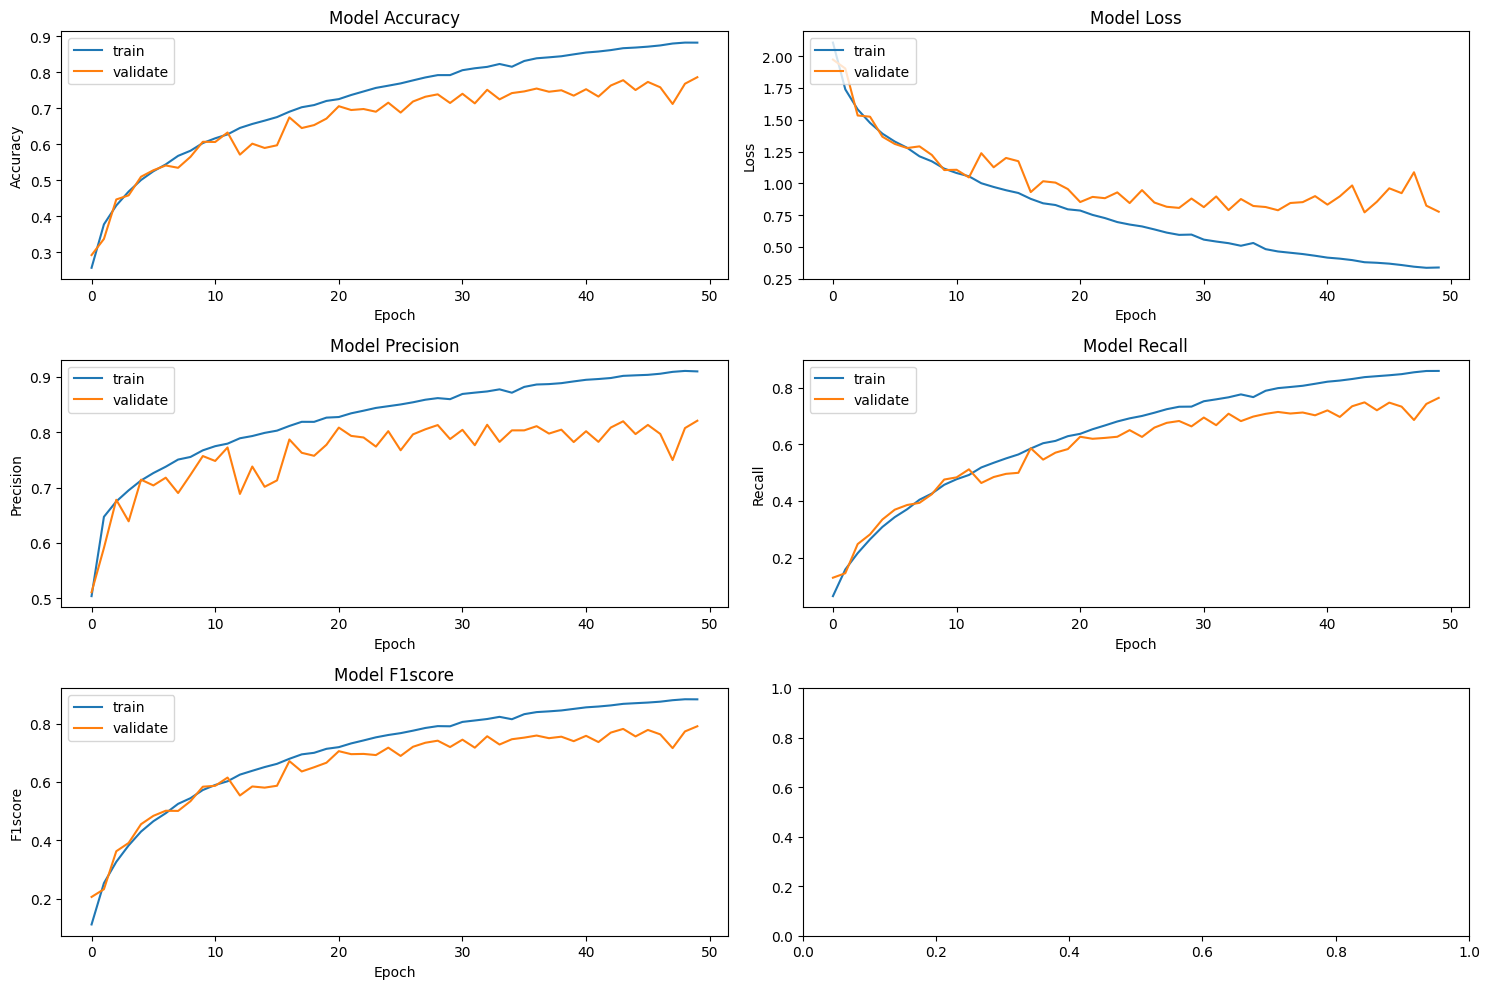

In [14]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  3.894094228744507
Accuracy of test set is:  0.35897406935691833
F1score of test set is:  0.35174721479415894
Precision of test set is:  0.3696156144142151
Recall of test set is:  0.3371480107307434


### Draw confusion matrix

In [16]:
label

array(['right little', 'right middle', 'right ring', 'right thumb',
       'right index', 'left little', 'left middle', 'left ring',
       'left thumb', 'left index'], dtype='<U12')

In [17]:
labels = list(label)
labels

['right little',
 'right middle',
 'right ring',
 'right thumb',
 'right index',
 'left little',
 'left middle',
 'left ring',
 'left thumb',
 'left index']

9244/9244 [==============================] - 79s 8ms/step


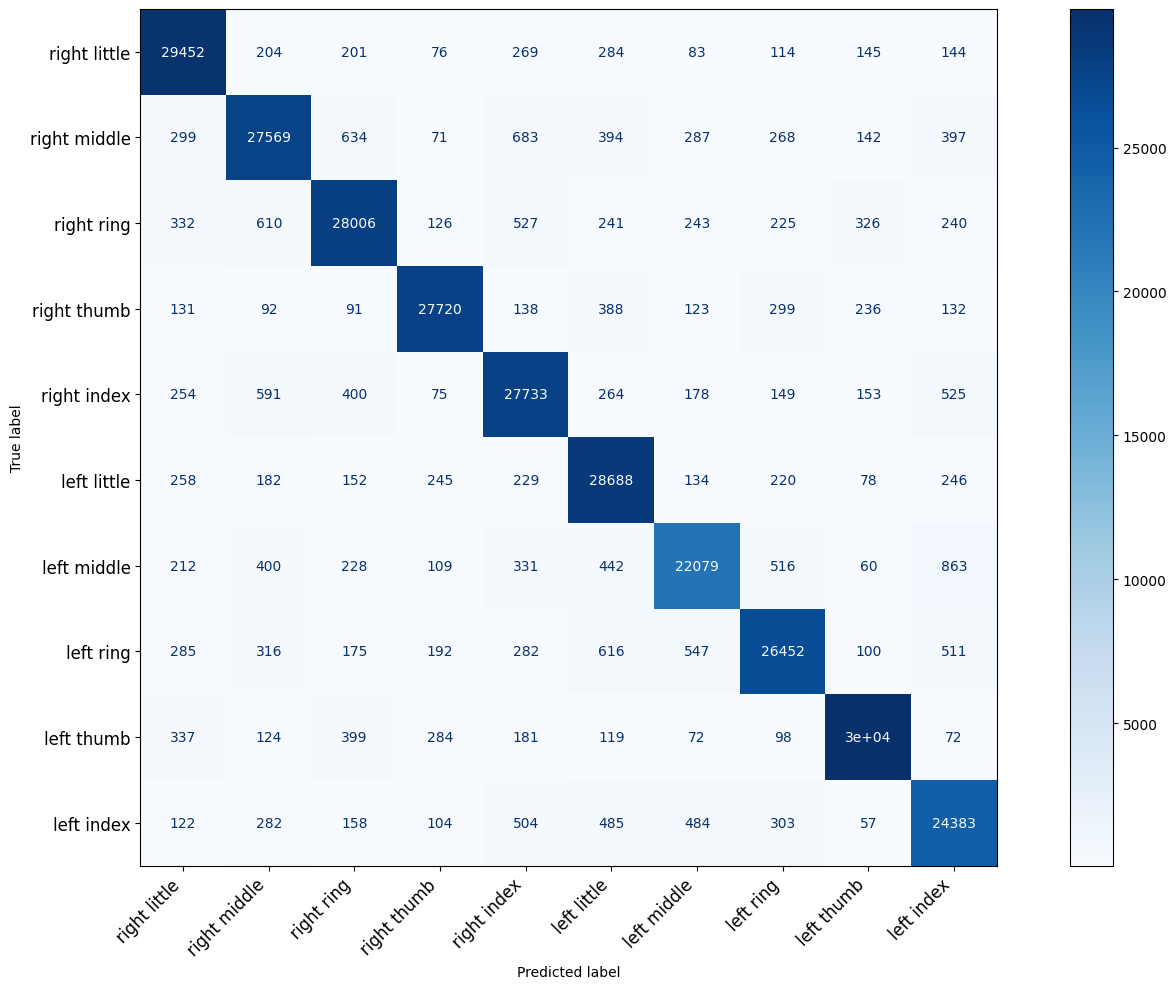

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


2687/2687 [==============================] - 22s 8ms/step


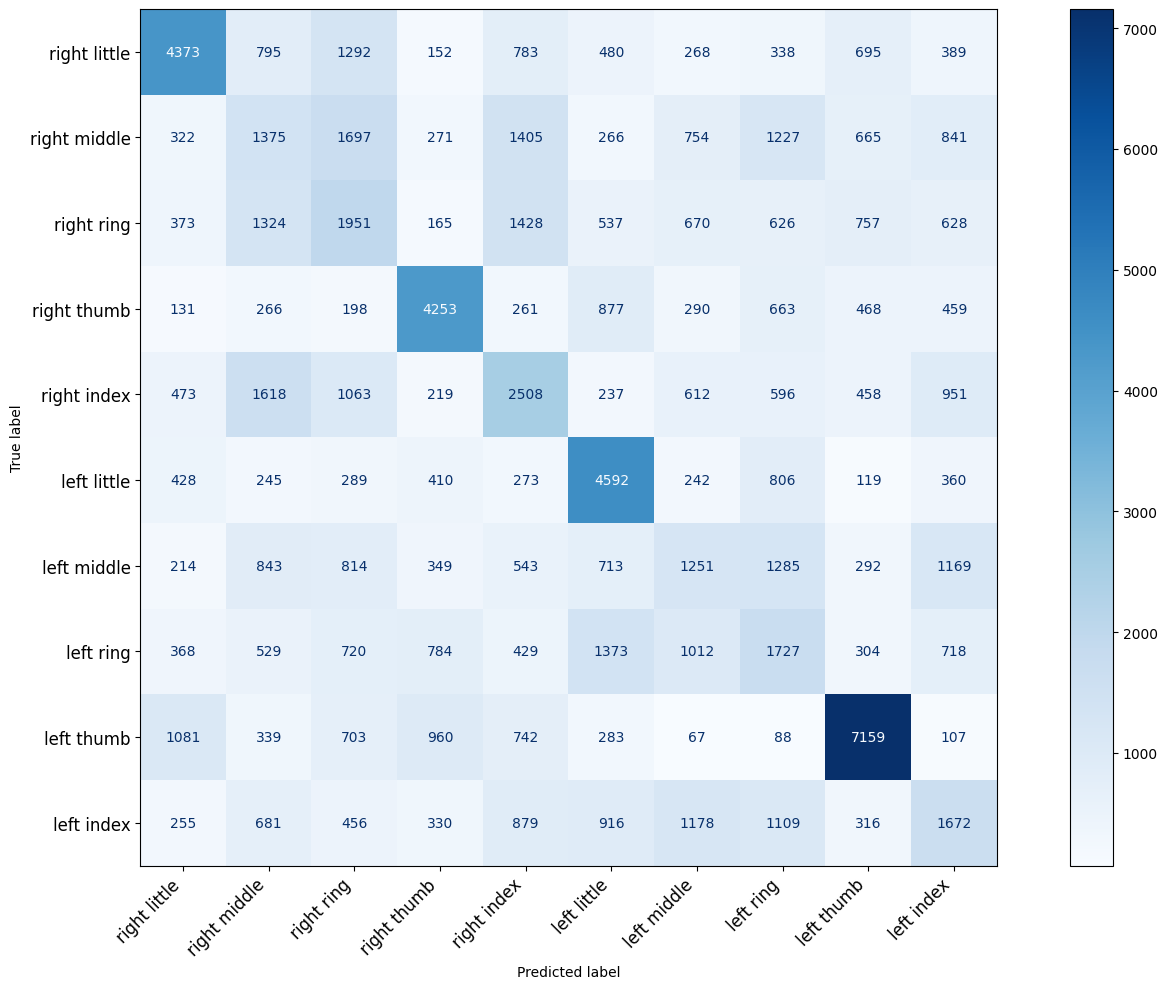

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [20]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((295791, 32, 32, 1), (295791, 10), (85970, 32, 32, 1), (85970, 10))